In [48]:

from __future__ import division
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import control
import control.matlab as mlab

import scipy.linalg as sla
from sympy import Matrix
import numpy.linalg as la

## Edit this so that you are pointing to where you keep the utils folder which has in it _547utils.py
import sys
sys.path.insert(0, '/Users/ratlifflj/repos/teach/2022/W22-547/src/jpyntbks/')
from utils._547utils import *


%load_ext autoreload
%autoreload 2
lw=4
fs=20

import seaborn as sns
sns.set_theme()
sns.set_style('whitegrid')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
# Randomly generate a system
n=2; m=1; p=1
np.random.seed(10)
A=np.random.rand(n,n)
B=np.random.rand(n,m)
C=np.random.rand(p,n)
D=np.random.rand(p,m)
sys1=control.StateSpace(A,B,C,D)
print('A :\n',sys1.A)
print('B :\n', sys1.B)
print('C :\n', sys1.C)
print('D :\n', sys1.D)



A :
 [[0.77132064 0.02075195]
 [0.63364823 0.74880388]]
B :
 [[0.49850701]
 [0.22479665]]
C :
 [[0.19806286 0.76053071]]
D :
 [[0.16911084]]


### Matrix exponential
Solutions to autonomous ODEs:
$$x(t)=e^{A(t-t_0)}x_0$$

In [50]:
# direct matrix exponential
sla.expm(A)

array([[2.17674837, 0.04447442],
       [1.35799951, 2.1284917 ]])

Recall the Jordan form:
$$J=P^{-1}AP$$

In [51]:
# Compute the jordan form 
A_=Matrix(A)
P,J=A_.jordan_form()
J=np.asarray(J).astype(np.float64) # uses sympy so we need to convert back to numpy arrays
P=np.asarray(P).astype(np.float64)

In [52]:
# matrix exponential via Jordan form
P@sla.expm(J)@la.inv(P)

array([[2.17674837, 0.04447442],
       [1.35799951, 2.1284917 ]])

## Numerical Simulation with Forward Euler
Consider $$\dot{x}=f(x)$$
We can simulate this system by numerically approximating the derivative using the forward Euler scheme:
$$\lim_{h\rightarrow 0}\frac{x(t+h)-x(t)}{h}=f(x(t)) \ \implies\ x_{k+1}=x_k+hf(x_k)$$

In [53]:
def feuler(f, T=None ,x0=[], dt=1e-3,MAXITERS=None, t0=0):
    '''
        T  :  final time
        f  :  dynamics, (t,x) --> R^n
        x  :  state, in R^n
        dt :  stepsize
        x0 :  initial state, in R^n
        
        (optional)
        MAXITERS : if you want to specify iterations, you can
        t0 : initial time
    '''
    n=len(x0)
    if T==None and MAXITERS!=None:
        T=MAXITERS*dt
    elif MAXITERS==None and T!=None:
        MAXITERS=int(T/dt)
    else:
        raise Exception('MAXITERS or T should be defined.')


    x=[x0]
    t=[t0]
    for i in range(MAXITERS-1):
        x.append(x[-1]+dt*f(t[-1],x[-1]))
        t.append(t[-1]+dt)
    return np.asarray(t),np.asarray(x).reshape(MAXITERS,n)

In [54]:
f=lambda t,x: -A@x
x0=np.random.rand(n)

In [55]:
t,x=feuler(f,T=10,t0=0,x0=x0,MAXITERS=None, dt=1e-2)

Text(0, 0.5, 'state')

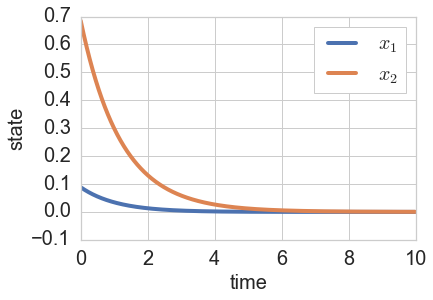

In [56]:
plt.figure(figsize=(6,4))

plt.plot(t,x[:,0], label=r'$x_1$', linewidth=4)
plt.plot(t,x[:,1], label=r'$x_2$', linewidth=4)
plt.legend(fontsize=20)
plt.tick_params(labelsize=20)
plt.xlabel('time', fontsize=20)
plt.ylabel('state', fontsize=20)

### Comparing to the forward Euler implementation in _547utils
`t`  : final simulation time, to be consistent with above t=1000*1e-2=10

`dt` : stepsize

`f`  : function of t and x


In [57]:
f=lambda t,x: -A@x
t,x=forward_euler(f,10,x0,t0=0.,dt=1e-2)

Text(0, 0.5, 'state')

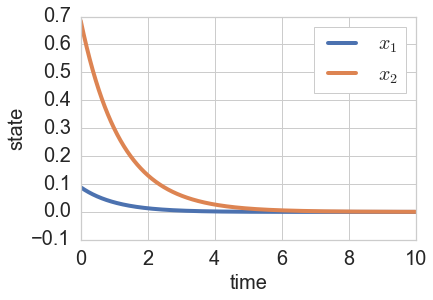

In [58]:
plt.figure(figsize=(6,4))

plt.plot(t,x[:,0], label=r'$x_1$', linewidth=4)
plt.plot(t,x[:,1], label=r'$x_2$', linewidth=4)
plt.legend(fontsize=20)
plt.tick_params(labelsize=20)
plt.xlabel('time', fontsize=20)
plt.ylabel('state', fontsize=20)

## System model
Consider the simple pendulum model (see [1])
$$m\ddot{a} = -\frac{mg}{l} \sin(a) + \tau$$
where $a$ is pendulum angle, $l$ is rod length, $m$ is pendulum mass, $g$ is force due to gravity, and $\tau$ is an input torque arising from a motor attached to the rod at its pivot point.

If we measure or observe the pendulum angle (e.g. with an encoder on the pivot motor), then the ODE control system model is
$$\dot{x} = f(x,u),\ y = h(x)$$
where $x = (a,\dot{a})\in\mathbb{R}^2$, $u = \tau\in\mathbb{R}$, $f : \mathbb{R}^2 \times \mathbb{R} \rightarrow \mathbb{R}^2$ is defined by 
$$f((a,\dot{a}),u) = (\dot{a},\ddot{a}) = \left(\dot{a}, -\frac{g}{l} \sin(a) + \frac{1}{m}u\right),$$ 
and $h : \mathbb{R}^2 \rightarrow \mathbb{R}$ is defined by 
$$h(a,\dot{a}) = a.$$

`[1]`: [pendulum link](https://en.wikipedia.org/wiki/Pendulum_(mathematics))

## Simulation
To simulate the pendulum, we first implement Python versions of the ODE control system model; it'll be computationally expedient if both $f$ and $h$ accept $t$, $x$, and $u$ as arguments even though mathematically they may not depend on all three:

In [59]:
g,l,m = 9.81,.5,1. # m/sec^2, m, kg

def f(t,x,u):
    a,da = x # angle (rad), velocity (rad/sec)
    return np.array([da,-(g/l)*np.sin(a) + (1/m)*u])

def f_(t,x):
    a,da = x # angle (rad), velocity (rad/sec)
    return np.array([da,-(g/l)*np.sin(a)])

def h(t,x,u):
    a,da = x # angle (rad), velocity (rad/sec)
    return a # output only the angle

Note that $x_0 = (0,0)$ (i.e. zero angle and zero velocity) is an equilibrium:

In [60]:
x0 = [0,0]
print('x0 =',x0,'\nf(x0) =',f(0.,x0,0))

x0 = [0, 0] 
f(x0) = [0. 0.]


Now we can simulate and plot the result; recall that, for small angles, the period of the pendulum swing is (approximately) $2\pi\sqrt{l/g}$:

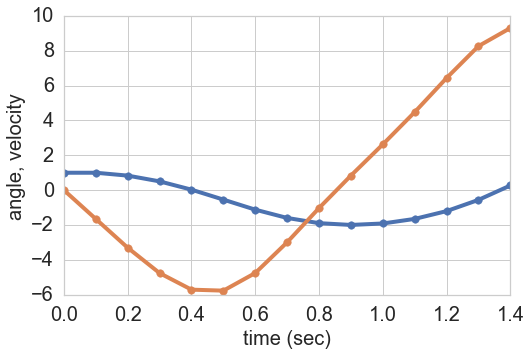

In [61]:
dt = 1e-1 # coarse timestep
T = 2*np.pi*np.sqrt(l/g) # approximately one period
x0 = [1.,0.] # "interesting" initial condition

u1 = lambda t : 0 # zero input function
# lambda is a shorthand way to define a function; equivalently:
def u1(t):
    return 0.

sim = forward_euler
t_,x_ = sim(f_,T,x0=x0,dt=dt) #,ut=u1)
# sim() returns arrays t_ and x_
# x_[j] is the state of the system (i.e. angle and velocity) at time t_[j]
plt.figure(figsize=(8,5))
plt.plot(t_,x_,'.-',markersize=15, linewidth=lw)
plt.xlabel('time (sec)', fontsize=fs)
plt.ylabel('angle, velocity',fontsize=fs)
plt.tick_params(labelsize=fs)

Clearly the timestep is too large -- forward Euler injected lots of energy over one cycle -- so let's simulate with progressively smaller timesteps:

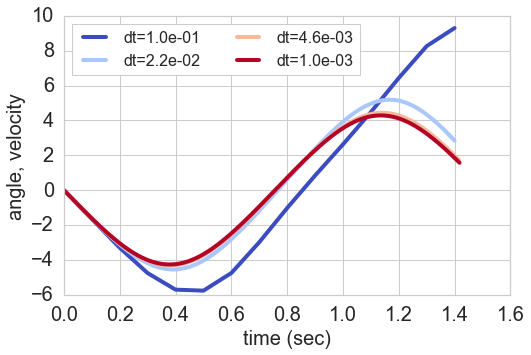

In [66]:
plt.figure(figsize=(8,5))
plt.xlabel('time (sec)', fontsize=fs)
plt.ylabel('angle, velocity', fontsize=fs)

num = 4
dts = np.logspace(-3,-1,num=num,base=10.)[::-1]
cols = mpl.cm.coolwarm(np.linspace(0.,1.,num=num))

for dt,col in zip(dts,cols):
    t_,x_ = sim(f,T,x0,dt=dt,ut=u1)
    plt.plot(t_,x_[:,1],'-',color=col,label=r'dt=%0.1e'%dt, linewidth=lw)
    
plt.legend(ncol=2,loc='upper left', fontsize=16)
plt.tick_params(labelsize=fs)

Now let's apply some classical Proportional-Derivative (PD) feedback control:  $u(x) = -k_p a - k_d \dot{a}$.

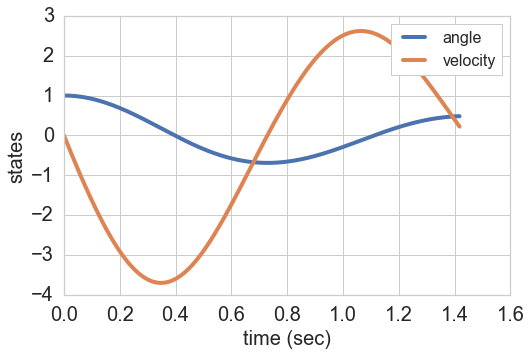

In [67]:
dt = 1e-3 
t1 = 1 * 2*np.pi*np.sqrt(l/g) 
x1 = [1.,0.] # "interesting" initial condition


kp,kd = 1.,1.
u1 = lambda t,x : -kp*x[0] - kd*x[1] # PD controller
sim=forward_euler
t_,x_ = sim(f,t1,x1,dt=dt,utx=u1)
# sim() returns arrays t_ and x_
# x_[j] is the state of the system (i.e. angle and velocity) at time t_[j]
plt.figure(figsize=(8,5))
arrayPLT=plt.plot(t_,x_,'-', linewidth=lw)
plt.xlabel('time (sec)', fontsize=fs)
plt.ylabel('states', fontsize=fs)
plt.tick_params(labelsize=fs)
plt.legend(iter(arrayPLT), ('angle', 'velocity'), fontsize=16)

If we're given the derivative of the vector field function with respect to state, then we can approximate the linearization along a simulation trajectory.  Let's start with $D_x f$, the (Jacobian) derivative of the vector field $f$ with respect to the state $x = (a,\dot{a})$:
$$D_x f(x,u) = \left[ \begin{array}{cc} 0 & 1 \\ -\frac{g}{l}\cos(a) & 0 \end{array} \right]$$

In [68]:
def Dxf(x):
    a,da = x # angle (rad), velocity (rad/sec)
    return np.array([[0.,1.],[-(g/l)*np.cos(a),0.]])

Let's verify this is the derivative using finite-central-differences; we already wrote a function that applies to general $g:\mathbb{R}^n\rightarrow\mathbb{R}^m$:
$$D_y g(y)e_j \approx \frac{1}{2\delta}(g(y+\delta e_j) - g(y - \delta e_j)),\ \delta\ll 1$$
So we'll check that we get (approximately) the same result with the two methods (repeatedly press "Ctrl + Enter" to check at new random state):

In [69]:
np.random.seed(10)
x = np.random.randn(2)
print(x)
print(Dxf(x))
print(Df(lambda x : f(0.,x,0.), x, d=1e-6))

[1.3315865  0.71527897]
[[ 0.          1.        ]
 [-4.64866515  0.        ]]
[[ 0.          1.        ]
 [-4.64866515  0.        ]]


Let's check the sensitivity to the discretization prameter

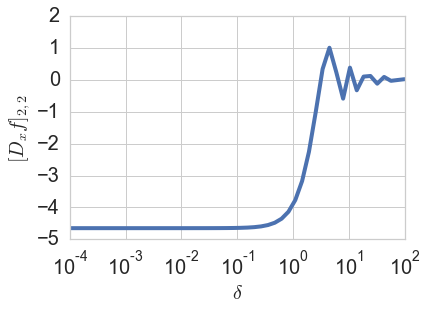

In [70]:
d = np.logspace(-4,2)
Dd = np.asarray([Df(lambda x : f(0.,x,0.), x, d=dd) for dd in d])
Dd.shape = (len(d),4)
plt.plot(figsize=(8,5))
plt.plot(d,Dd[:,2], linewidth=lw)
plt.xscale('log')
plt.xlabel('$\\delta$', fontsize=fs)
plt.ylabel('$[D_x f]_{2,2}$', fontsize=fs)
plt.tick_params(labelsize=fs)

Now to linearize along a trajectory, we need to define an auxiliary linear time-varying ODE:
\begin{eqnarray*}
\dot{\Phi}(s,0) &=& A(s) \Phi(s,0),\\
\Phi(0,0) &=& I,\\
A(s) &=&D_x f(s,x(s),u(s))
\end{eqnarray*}

In [71]:
def F(s,X,u): # assumes 0 <= s <= t
    j = np.int(s/dt)
    As = Dxf(x_[j]) # note: we're evaluating Dxf along the simulation x_
    return As@X #np.dot(As,X)

Then we can apply the same simulation algorithm to this (linear time-varying) ODE (i.e. the simulation algorithm doesn't need to know the system is LTV):

In [72]:
x1

[1.0, 0.0]

In [73]:
dt = 1e-5

u1 = lambda t : 0 # zero input function

t_,x_ = sim(f,t1,x1,dt=dt,ut=u1)

X1 = np.identity(2)
print(X1)
T_,X_ = sim(F,t1,X1,dt=dt,ut=u1)

[[1. 0.]
 [0. 1.]]


For convenience, we defined a simulation function $$\psi:\mathbb{N}\times\mathbb{R}^2\times U^\mathbb{R}\rightarrow \mathbb{R}^2$$ that approximates the flow $$\phi:\mathbb{R}\times\mathbb{R}^2\times U^\mathbb{R}\rightarrow \mathbb{R}^2.$$  If we haven't made a mistake, then $$D_x\phi(t,x) \approx D_x\psi(t,x) \approx X(t)$$

In [74]:
print(np.round(X_[-1],2))
print(np.round(Df(lambda x : psi(f,t1,x,ut=u1,dt=dt), x1, d=1e-6),2))

[[ 0.65 -0.09]
 [ 4.16  0.95]]
[[ 0.65 -0.09]
 [ 4.16  0.95]]
